# **Notebook para Entrenamiento y Afinamiento de Random Forest**
Basado en datos de FlightRadar24 y sintéticos de spoofing.
Se asume que el usuario tiene 3 archivos CSV:
  - train_data.csv (datos íntegros de vuelos históricos + etiquetas generadas)
  - val_data.csv   (datos íntegros de vuelos históricos + etiquetas generadas)
  - test_data.csv  (datos íntegros de vuelos históricos + etiquetas generadas)

###Cada CSV debe tener al menos las columnas:
*   UTC
*   Callsign
*   Latitude
*   Longitude
*   Altitude
*   Speed
*   Direction
*   Label: Label = 1 (íntegro) o 0 (no íntegro / spoofing)


### **Estructura del notebook:**
1. Instalación de dependencias
2. Cargue de archivos CSV (train_data.csv/val_data.csv/test_data.csv)
3. Importe y carga de datos
4. Preparación de datos: limpieza, transformación, generación de spoofing sintético
5. División de conjuntos y descripción
6. Normalización con StandardScaler
7. Distribución de clases
8. Entrenamiento con mejores hiperparámetros
9. Evaluación final en conjunto de prueba e impresión de métricas
10. Entrenamiento final y evaluación en test
11. Exportar modelo final


# **1. Instalación de dependencias**

In [ ]:
# === 1: Instalación de dependencias ===
!pip install --upgrade --force-reinstall pandas numpy scikit-learn joblib xgboost lightgbm imbalanced-learn
#
#    numpy - for ndarrays
#    pandas - for DataFrames
#    scikit-learn
#    joblib
#    xgboost
#    lightgbm
#    matplotlib.pyplot - for plotting
#    imbalanced-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 664.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 840.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **2. Cargue de archivos CSV (train_data.csv/val_data.csv/test_data.csv)**

In [ ]:
# === 2: Cargue de archivos CSV (train/val/test) ===
from google.colab import files

print("🔃 Cargar aquí los archivos: train_data.csv, val_data.csv, test_data.csv")
uploaded = files.upload()


🔃 Sube aquí tus archivos: train_data.csv, val_data.csv, test_data.csv


Saving test_data2.csv to test_data2.csv
Saving train_data2.csv to train_data2.csv
Saving val_data2.csv to val_data2.csv


# **3. Importe y carga de datos**

In [ ]:
# === 3: Importe y carga de datos ===
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from math import radians, sin, cos, sqrt, atan2, degrees
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    RocCurveDisplay
)
from imblearn.over_sampling import SMOTE  # opcional

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

# Lectura de CSVs (suponemos que se han subido con nombres correctos)
train_df = pd.read_csv("train_data.csv", parse_dates=["UTC"])
val_df   = pd.read_csv("val_data.csv",   parse_dates=["UTC"])
test_df  = pd.read_csv("test_data.csv",  parse_dates=["UTC"])

print("✅ Datos cargados:")
print(f"  Train: {train_df.shape}")
print(f"  Val:   {val_df.shape}")
print(f"  Test:  {test_df.shape}")


✅ Datos cargados:
  Train: (3184, 8)
  Val:   (749, 8)
  Test:  (940, 8)


# **4. Preparación de datos: limpieza, transformación, generación de spoofing sintético**

In [ ]:
# === 4.1: Limpieza de datos ===
def clean_df(df, name):
    before = df.shape[0]
    # Eliminar duplicados exactos
    df = df.drop_duplicates()
    # Eliminar filas con valores nulos en columnas clave
    df = df.dropna(subset=["Latitude", "Longitude", "Altitude", "Speed", "Direction"])
    after = df.shape[0]
    print(f"[{name}] Filas eliminadas (duplicados/nulos): {before - after}")
    return df.reset_index(drop=True)

train_df = clean_df(train_df, "Train")
val_df   = clean_df(val_df,   "Val")
test_df  = clean_df(test_df,  "Test")


[Train] Filas eliminadas (duplicados/nulos): 0
[Val] Filas eliminadas (duplicados/nulos): 0
[Test] Filas eliminadas (duplicados/nulos): 0


In [ ]:
# === 4.2: Generar etiquetas que faltan ===
def generate_synthetic_labels(df, name, seed=42, ratio=0.2):
    """
    Si 'Label' no existe, crea la columna y asigna 0/1 sintético (20% anomalías).
    """
    if "Label" not in df.columns:
        n = df.shape[0]
        labels = np.ones(n, dtype=int)
        np.random.seed(seed)
        idx_anom = np.random.choice(n, int(n * ratio), replace=False)
        labels[idx_anom] = 0
        df["Label"] = labels
        print(f"[{name}] Etiquetas sintéticas generadas: {len(idx_anom)} anomalías (Label=0)")
    else:
        print(f"[{name}] Ya existe columna 'Label' → no se regeneran.")
    return df

train_df = generate_synthetic_labels(train_df, "Train")
val_df   = generate_synthetic_labels(val_df,   "Val")
test_df  = generate_synthetic_labels(test_df,  "Test")

# Revisamos distribución de clases después
print("\nDistribución de etiquetas tras generación:")
print("Train:\n", train_df["Label"].value_counts(normalize=True))
print("Val:\n",   val_df["Label"].value_counts(normalize=True))
print("Test:\n",  test_df["Label"].value_counts(normalize=True))


[Train] Ya existe columna 'Label' → no se regeneran.
[Val] Ya existe columna 'Label' → no se regeneran.
[Test] Ya existe columna 'Label' → no se regeneran.

Distribución de etiquetas tras generación:
Train:
 Label
1    0.800251
0    0.199749
Name: proportion, dtype: float64
Val:
 Label
1    0.801068
0    0.198932
Name: proportion, dtype: float64
Test:
 Label
1    0.8
0    0.2
Name: proportion, dtype: float64


# **5. División de conjuntos y descripción**

In [ ]:
# === 5.1: Función Harversine ===
# Esta función se en carga de
# Calcular la distancia entre dos coordenadas geográficas sobre la superficie terrestre.
# Calcular el rumbo inicial o azimut desde el primer punto hacia el segundo.
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # radio terrestre en metros
    φ1, φ2 = radians(lat1), radians(lat2)
    Δφ = radians(lat2 - lat1)
    Δλ = radians(lon2 - lon1)
    a = sin(Δφ/2)**2 + cos(φ1)*cos(φ2)*sin(Δλ/2)**2
    d = 2 * R * atan2(sqrt(a), sqrt(1 - a))
    y = sin(Δλ) * cos(φ2)
    x = cos(φ1)*sin(φ2) - sin(φ1)*cos(φ2)*cos(Δλ)
    θ = (degrees(atan2(y, x)) + 360) % 360
    return d, θ


In [ ]:
# === 5.2: Función para extraer variables ===
def prepare_features(df):
    """
    Dado un DataFrame con columnas UTC, Latitude, Longitude, Altitude, Speed, Direction, Label,
    devuelve:
      X: DataFrame con columnas [dist, bearing, Altitude, Speed, Direction, hour, minute]
      y: array de etiquetas (omitimos la primer fila)
    """
    df = df.sort_values("UTC").reset_index(drop=True)
    n = df.shape[0]

    dists, bears = [0.0], [0.0]  # colocar ceros para la fila 0
    for i in range(1, n):
        lat0, lon0 = df.loc[i-1, "Latitude"], df.loc[i-1, "Longitude"]
        lat1, lon1 = df.loc[i,   "Latitude"], df.loc[i,   "Longitude"]
        d, b = haversine(lat0, lon0, lat1, lon1)
        dists.append(d)
        bears.append(b)

    # Extraemos Altitude, Speed, Direction, hora y minuto
    altitude = df["Altitude"].values
    speed    = df["Speed"].values
    direction= df["Direction"].values
    hour     = df["UTC"].dt.hour.values
    minute   = df["UTC"].dt.minute.values

    X = pd.DataFrame({
        "dist":      np.array(dists, dtype=np.float32),
        "bearing":   np.array(bears, dtype=np.float32),
        "altitude":  altitude.astype(np.float32),
        "speed":     speed.astype(np.float32),
        "direction": direction.astype(np.float32),
        "hour":      hour.astype(np.int32),
        "minute":    minute.astype(np.int32)
    })

    # Las etiquetas, salvo la primer fila (no tiene feature de continuidad significativo)
    y = df["Label"].values.copy()
    return X.iloc[1:].reset_index(drop=True), y[1:]

# Aplicamos a cada conjunto
X_train, y_train = prepare_features(train_df)
X_val,   y_val   = prepare_features(val_df)
X_test,  y_test  = prepare_features(test_df)

print("\n✅ Features construidos:")
print(f"  X_train: {X_train.shape},   y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape},  y_test:  {y_test.shape}")



✅ Features construidos:
  X_train: (3183, 7),   y_train: (3183,)
  X_val:   (748, 7),   y_val:   (748,)
  X_test:  (939, 7),  y_test:  (939,)


# **6. Normalización con StandardScaler**

In [ ]:
# === 6: Normalización con StandardScaler ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("✅ Normalización completada:")
print(f"  X_train_scaled: {X_train_scaled.shape}, X_val_scaled: {X_val_scaled.shape}, X_test_scaled: {X_test_scaled.shape}")


✅ Normalización completada:
  X_train_scaled: (3183, 7), X_val_scaled: (748, 7), X_test_scaled: (939, 7)


# **7. Distribución de clases**

In [ ]:
# === 7: Distribución de clases ===
from collections import Counter

print("Distribución de clases:")
print("  Train:", Counter(y_train))
print("  Val:  ", Counter(y_val))
print("  Test: ", Counter(y_test))

# Convertimos a DataFrame para %:
def print_percentages(y, name):
    counts = Counter(y)
    total = len(y)
    print(f"{name}:")
    for cls, cnt in counts.items():
        print(f"  Class {cls}: {cnt} ({cnt/total:.2%})")

print_percentages(y_train, "  Train")
print_percentages(y_val,   "  Val")
print_percentages(y_test,  "  Test")


Distribución de clases:
  Train: Counter({np.int64(1): 2547, np.int64(0): 636})
  Val:   Counter({np.int64(1): 599, np.int64(0): 149})
  Test:  Counter({np.int64(1): 751, np.int64(0): 188})
  Train:
  Class 0: 636 (19.98%)
  Class 1: 2547 (80.02%)
  Val:
  Class 1: 599 (80.08%)
  Class 0: 149 (19.92%)
  Test:
  Class 1: 751 (79.98%)
  Class 0: 188 (20.02%)


# **8. Entrenamiento con mejores hiperparámetros:**

In [ ]:
# === 8.1: Configuración de Grid y Stratified CV ===
param_grid = {
    "n_estimators":      [200, 500],
    "max_depth":         [None, 10, 20],
    "max_features":      ["sqrt", "log2"],
    "min_samples_split": [2, 5]
}

# Usamos StratifiedKFold para mantener proporciones de clases en cada fold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


In [ ]:
# === 8.2: Gridsearchcv para RF (sin class_weight) ===
rf_plain = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_plain = GridSearchCV(
    estimator=rf_plain,
    param_grid=param_grid,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

print("\n[INFO] Iniciando GridSearchCV (RF sin class_weight)...")
grid_plain.fit(X_train_scaled, y_train)
print("[RESULT] RF sin pesos - Mejores parámetros:")
print(grid_plain.best_params_)
print("Mejor AUC CV (sin pesos):", grid_plain.best_score_)



[INFO] Iniciando GridSearchCV (RF sin class_weight)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[RESULT] RF sin pesos - Mejores parámetros:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Mejor AUC CV (sin pesos): 0.8895667118548642


In [ ]:
# === 8.3: Gridsearchcv para RF (con class_weight) ===
rf_weighted = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

grid_weighted = GridSearchCV(
    estimator=rf_weighted,
    param_grid=param_grid,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

print("\n[INFO] Iniciando GridSearchCV (RF con class_weight='balanced')...")
grid_weighted.fit(X_train_scaled, y_train)
print("[RESULT] RF con pesos - Mejores parámetros:")
print(grid_weighted.best_params_)
print("Mejor AUC CV (con pesos):", grid_weighted.best_score_)



[INFO] Iniciando GridSearchCV (RF con class_weight='balanced')...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[RESULT] RF con pesos - Mejores parámetros:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Mejor AUC CV (con pesos): 0.8932854782911454


# **9. Evaluación final en conjunto de prueba e impresión de métricas**


=== Métricas en Validación ===


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
RF_plain,0.828877,0.938547,0.841402,0.887324,0.901895
RF_weighted,0.834225,0.983707,0.806344,0.886239,0.902164



Matriz de Confusión RF_plain:
 [[116  33]
 [ 95 504]]
Matriz de Confusión RF_weighted:
 [[141   8]
 [116 483]]


<Figure size 800x600 with 0 Axes>

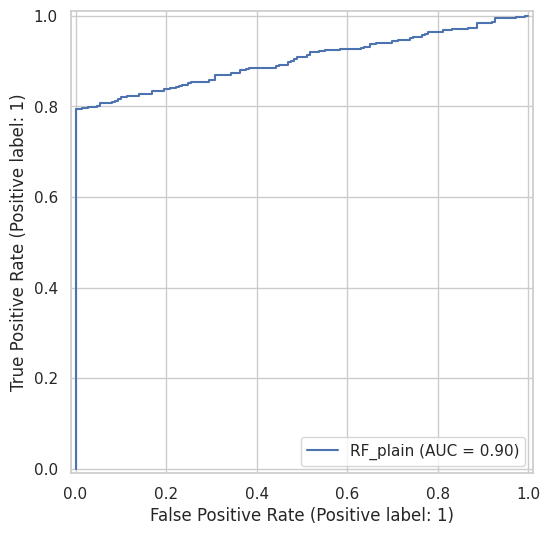

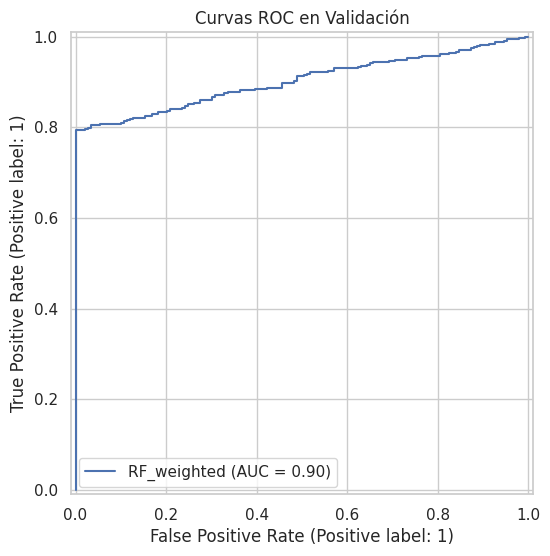

In [ ]:
# === CELDA 9: Evaluar modelos en validación ===
def evaluate(name, model, X, y_true):
    """
    Calcula métricas y devuelve un dict con:
      Accuracy, Precision, Recall, F1, AUC y Matriz de Confusión.
    """
    results = {"Model": name}
    y_pred = model.predict(X)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y_true, probs)
    else:
        # Si no hay parametros de spoofing (rare), colocamos nan:
        auc = np.nan

    results["Accuracy"]  = accuracy_score(y_true, y_pred)
    results["Precision"] = precision_score(y_true, y_pred, zero_division=0)
    results["Recall"]    = recall_score(y_true, y_pred, zero_division=0)
    results["F1"]        = f1_score(y_true, y_pred, zero_division=0)
    results["AUC"]       = auc
    results["ConfMatrix"]= confusion_matrix(y_true, y_pred)
    return results

# Extraemos los mejores estimadores
best_plain = grid_plain.best_estimator_
best_wt    = grid_weighted.best_estimator_

# Evaluamos en X_val_scaled
res_plain = evaluate("RF_plain", best_plain, X_val_scaled, y_val)
res_wt    = evaluate("RF_weighted", best_wt,    X_val_scaled, y_val)

# Mostramos métricas
df_val_metrics = pd.DataFrame([
    {
        "Model": r["Model"],
        "Accuracy": r["Accuracy"],
        "Precision": r["Precision"],
        "Recall": r["Recall"],
        "F1": r["F1"],
        "AUC": r["AUC"]
    }
    for r in (res_plain, res_wt)
]).set_index("Model")

print("\n=== Métricas en Validación ===")
display(df_val_metrics)

# Imprimimos matrices de confusión
print("\nMatriz de Confusión RF_plain:\n", res_plain["ConfMatrix"])
print("Matriz de Confusión RF_weighted:\n", res_wt["ConfMatrix"])

# Graficar Curvas ROC en Validación
plt.figure()
for r in (res_plain, res_wt):
    name = r["Model"]
    model = best_plain if name == "RF_plain" else best_wt
    probs = model.predict_proba(X_val_scaled)[:,1]
    RocCurveDisplay.from_predictions(y_val, probs, name=name)
plt.title("Curvas ROC en Validación")
plt.legend()
plt.show()


# **10. Entrenamiento final y evaluación en test**


[INFO] Modelo final elegido: RF_weighted
[INFO] Entrenamiento final completado (train+val).

=== Métricas Finales en Test ===
Accuracy:  0.8435
Precision: 0.9903
Recall:    0.8123
F1-score:  0.8925
AUC:       0.9106
Confusion Matrix:
 [[182   6]
 [141 610]]


<Figure size 800x600 with 0 Axes>

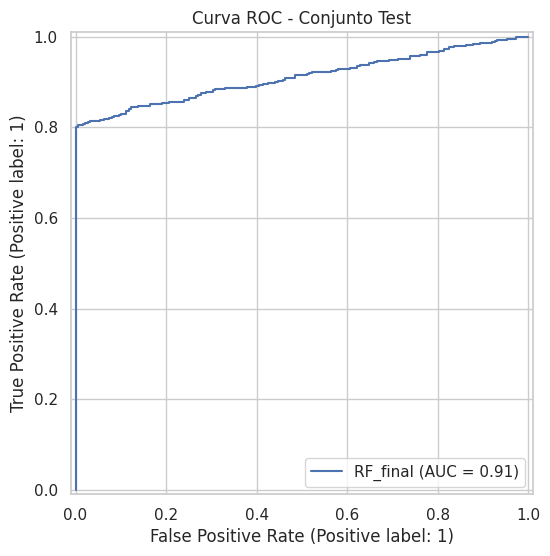

In [ ]:
# === 10: Entrenamiento final y evaluación en test ===
# Determinamos cuál de los dos obtuvo mejor AUC CV
if grid_weighted.best_score_ >= grid_plain.best_score_:
    final_model = RandomForestClassifier(
        **grid_weighted.best_params_,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    chosen = "RF_weighted"
else:
    final_model = RandomForestClassifier(
        **grid_plain.best_params_,
        random_state=42,
        n_jobs=-1
    )
    chosen = "RF_plain"

print(f"\n[INFO] Modelo final elegido: {chosen}")

# Reentrenamos sobre train + val combinados
X_comb = np.vstack([X_train_scaled, X_val_scaled])
y_comb = np.concatenate([y_train, y_val])

# Si el modelo elegido es weight, ya instanciamos con class_weight="balanced"
# Sino, es el modelo “plain” sin weights
final_model.fit(X_comb, y_comb)
print("[INFO] Entrenamiento final completado (train+val).")

# Evaluación en test
res_test = evaluate("RF_final", final_model, X_test_scaled, y_test)
print("\n=== Métricas Finales en Test ===")
print(f"Accuracy:  {res_test['Accuracy']:.4f}")
print(f"Precision: {res_test['Precision']:.4f}")
print(f"Recall:    {res_test['Recall']:.4f}")
print(f"F1-score:  {res_test['F1']:.4f}")
print(f"AUC:       {res_test['AUC']:.4f}")
print("Confusion Matrix:\n", res_test["ConfMatrix"])

# Curva ROC en test
plt.figure()
probs_test = final_model.predict_proba(X_test_scaled)[:,1]
RocCurveDisplay.from_predictions(y_test, probs_test, name="RF_final")
plt.title("Curva ROC - Conjunto Test")
plt.show()


# **11. Exportar modelo final**

In [ ]:
# === 11: Exportar modelo final ===
import joblib

model_filename = "rf_best_model.pkl"
scaler_filename= "scaler.pkl"

joblib.dump(final_model, model_filename)
joblib.dump(scaler, scaler_filename)
print(f"\n✅ Modelo final guardado como '{model_filename}'")
print(f"✅ Scaler guardado como '{scaler_filename}'")

from google.colab import files as gfiles
gfiles.download(model_filename)
gfiles.download(scaler_filename)


NameError: name 'final_model' is not defined